In [1]:
import sys
sys.path.append("/Users/sklim/Projects/DamGeophysics/codes/")
from Readfiles import getFnames
from DCdata import readReservoirDC
from SimPEG.EM.Static import DC
from SimPEG import EM
from SimPEG import Mesh, Utils
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
fname = "/Users/sklim/Projects/DamGeophysics/data/ChungCheonDC/20150101000000.apr"
survey = readReservoirDC(fname)
dobsAppres = survey.dobs
# fig, ax = plt.subplots(1,1, figsize = (10, 2))
# dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dtype='volt', sameratio=False)
# cb = dat[2]
# cb.set_label("Apprent resistivity (ohm-m)")
# geom = np.hstack(dat[3])
# dobsDC = dobsAppres * geom 

In [3]:
# problem = DC.Problem2D_CC(mesh)
cs = 2.
npad = 6
hx = [(cs,npad, -1.3),(cs,70),(cs/2,1),(cs/4,1),(cs/8,1),(cs/20,1),(0.1,25),(cs/20,1), (cs/8,1), (cs/4,1), (cs/2,1), (cs,70),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,2),(cs/2,1),(cs/4,1),(cs/8,1),(cs/20,1),(0.1,25),(cs/20,1), (cs/8,1), (cs/4,1), (cs/2,2),(cs,8)]
mesh = Mesh.TensorMesh([hx, hy])
mesh = Mesh.TensorMesh([hx, hy],x0=[-mesh.hx[:6].sum()-0.25, -mesh.hy.sum()])

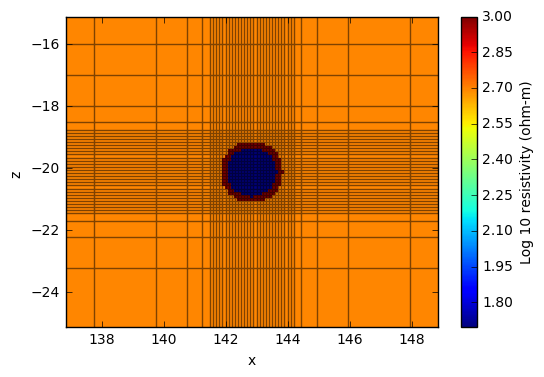

In [4]:
dx, dy = 5., 5.
x0, y0 = mesh.hx.sum()/2+mesh.x0[0], -20.1
coreinds0 = Utils.ModelBuilder.getIndicesSphere(np.r_[x0, y0], 1. ,mesh.gridCC)
coreinds1 = Utils.ModelBuilder.getIndicesSphere(np.r_[x0, y0], 0.8 ,mesh.gridCC)
phas1inds = Utils.ModelBuilder.getIndicesSphere(np.r_[x0, y0], 2. ,mesh.gridCC)
phas2inds = Utils.ModelBuilder.getIndicesSphere(np.r_[x0, y0], 4. ,mesh.gridCC)
phas3inds = Utils.ModelBuilder.getIndicesSphere(np.r_[x0, y0], 8. ,mesh.gridCC)

sigma0 = np.ones(mesh.nC)*1./500
sigma0[coreinds0] = 1e-3
sigma0[coreinds1] = 1./50
dat = mesh.plotImage(np.log10(1./sigma0), gridOpts={'alpha':0.5, 'color':'k'}, grid=True)
plt.axis('equal')
# plt.xlim(0, 280)
# plt.ylim(-25, 0)
plt.xlim(x0-dx, x0+dx)
plt.ylim(y0-dy, y0+dy)
plt.ylabel("z ")
cb = plt.colorbar(dat[0])
cb.set_label("Log 10 resistivity (ohm-m)")

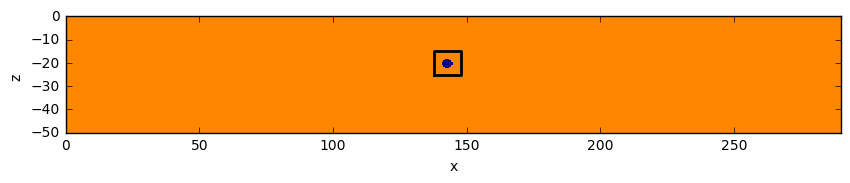

In [5]:
sigma1 = np.ones(mesh.nC)*1./500
sigma1[phas1inds] = 1./50
sigma1[coreinds0] = 1e-3
sigma1[coreinds1] = 1./50
fig, ax = plt.subplots(1,1, figsize = (10, 1.5))
dat = mesh.plotImage(np.log10(1./sigma1),grid=False, ax=ax, pcolorOpts={"cmap":"jet"})
ax.set_ylim(-50, 0)
ax.set_xlim(0, 290)
ax.set_ylabel("z ")
# cb = plt.colorbar(dat[0])
# cb.set_label("Log 10 resistivity (ohm-m)")
ax.plot(np.r_[x0-dx, x0+dx, x0+dx, x0-dx, x0-dx], np.r_[y0-dx, y0-dx, y0+dx, y0+dx, y0-dx], 'k-', lw=2)

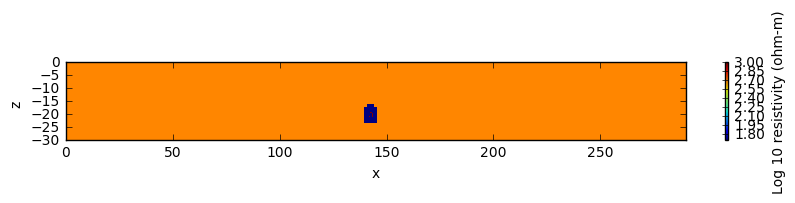

In [6]:
sigma2 = np.ones(mesh.nC)*1./500
sigma2[phas2inds] = 1./50
sigma2[coreinds0] = 1e-3
sigma2[coreinds1] = 1./50
fig, ax = plt.subplots(1,1, figsize = (10, 1.))
dat = mesh.plotImage(np.log10(1./sigma2),grid=False, ax=ax, pcolorOpts={"cmap":"jet"})
ax.set_ylim(-30, 0)
ax.set_xlim(0, 290)
ax.set_ylabel("z ")
cb = plt.colorbar(dat[0])
cb.set_label("Log 10 resistivity (ohm-m)")

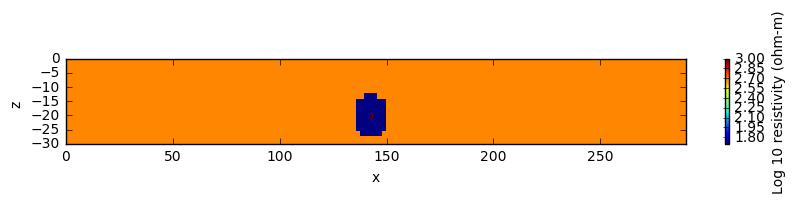

In [7]:
sigma3 = np.ones(mesh.nC)*1./500
sigma3[phas3inds] = 1./50
sigma3[coreinds0] = 1e-3
sigma3[coreinds1] = 1./50
fig, ax = plt.subplots(1,1, figsize = (10, 1.1))
dat = mesh.plotImage(np.log10(1./sigma3),grid=False, ax=ax, pcolorOpts={"cmap":"jet"})
ax.set_ylim(-30, 0)
ax.set_xlim(0, 290)
ax.set_ylabel("z ")
cb = plt.colorbar(dat[0])
cb.set_label("Log 10 resistivity (ohm-m)")

In [8]:
def from3Dto2Dsurvey(survey):
    srcLists2D = []
    nSrc = len(survey.srcList)

    for iSrc in range (nSrc):
        src = survey.srcList[iSrc]
        locsM = np.c_[src.rxList[0].locs[0][:,0], np.ones_like(src.rxList[0].locs[0][:,0])*-0.75] 
        locsN = np.c_[src.rxList[0].locs[1][:,0], np.ones_like(src.rxList[0].locs[1][:,0])*-0.75] 
        rx = DC.Rx.Dipole_ky(locsM, locsN)
        locA = np.r_[src.loc[0][0], -0.75]
        locB = np.r_[src.loc[1][0], -0.75]
        src = DC.Src.Dipole([rx], locA, locB)
        srcLists2D.append(src)
    survey2D = DC.Survey_ky(srcLists2D)
    return survey2D

In [9]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)

In [10]:
mapping = Maps.ExpMap(mesh)
survey2D = from3Dto2Dsurvey(survey)
problem = DC.Problem2D_N(mesh, sigmaMap=mapping)
problem.pair(survey2D)
m0 = np.log(sigma0)
m1 = np.log(sigma1)
m2 = np.log(sigma2)
m3 = np.log(sigma3)


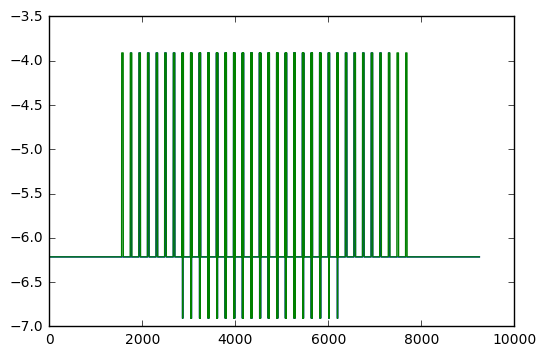

In [11]:
plt.plot(m1)
plt.plot(m2)

<function __main__.foo>

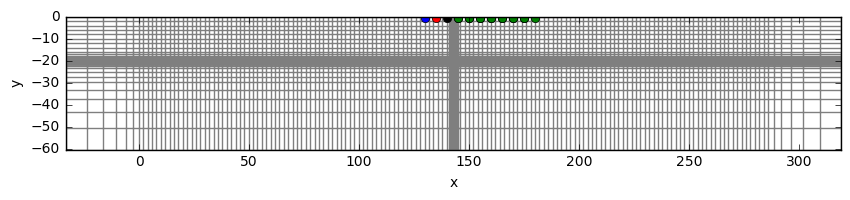

In [12]:
from ipywidgets import interact
nSrc = len(survey2D.srcList)
def foo(isrc):
    figsize(10, 5)
    mesh.plotImage(np.ones(mesh.nC)*np.nan, gridOpts={"color":"k", "alpha":0.5}, grid=True)
#     isrc=0
    src = survey2D.srcList[isrc]
    plt.plot(src.loc[0][0], src.loc[0][1], 'bo')
    plt.plot(src.loc[1][0], src.loc[1][1], 'ro')
    locsM = src.rxList[0].locs[0]
    locsN = src.rxList[0].locs[1]
    plt.plot(locsM[:,0], locsM[:,1], 'ko')
    plt.plot(locsN[:,0], locsN[:,1], 'go')
    plt.gca().set_aspect('equal', adjustable='box')
    
interact(foo, isrc=(0, nSrc-1, 1))

In [13]:
pred0 = survey2D.dpred(m0)

In [ ]:
pred1 = survey2D.dpred(m1)

In [ ]:
pred2 = survey2D.dpred(m2)

In [ ]:
pred3 = survey2D.dpred(m3)

In [ ]:
vmin, vmax = 2, 3.

In [ ]:
#dat = EM.Static.Utils.StaticUtils.plot_pseudoSection??

In [ ]:
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection

In [ ]:
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection

In [ ]:
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection

In [ ]:
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection

In [ ]:
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection

In [ ]:
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection

In [ ]:
survey.dobs = pred0.copy()
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dataType='appResistivity', sameratio=False, scale="log", clim=(vmin, vmax))

In [ ]:
survey.dobs = pred1.copy()
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dataType='appResistivity', sameratio=False, scale="log", clim=(vmin, vmax))

In [ ]:
survey.dobs = pred2.copy()
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dataType='appResistivity', sameratio=False, scale="log", clim=(vmin, vmax))

In [ ]:
survey.dobs = pred3.copy()
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dataType='appResistivity', sameratio=False, scale="log", clim=(vmin, vmax))

In [ ]:
survey.dobs = abs(pred1.copy() - pred0.copy()) / abs (pred0.copy()) *100.
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dataType='volt', sameratio=False, scale="linear", clim=(5, 20))

In [ ]:
survey.dobs = abs(pred2.copy() - pred0.copy()) / abs (pred0.copy()) *100.
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dataType='volt', sameratio=False, scale="linear", clim=(5, 20))

In [ ]:
survey.dobs = abs(pred3.copy() - pred0.copy()) / abs (pred0.copy()) *100.
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dataType='volt', sameratio=False, scale="linear", clim=(5, 20))